In [3]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [4]:
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova

## Анализ оттока водителей сервиса такси
Есть данные о такси-компани, необходимо: 
1. изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются.  2 2. сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку"
3. сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения 
4. провести A/B тест и выяснить, стало ли лучше

### Структура данных

- **city** – город
- **phone** – основное устройство, которое использует водитель 
- **signup_date** – дата регистрации аккаунта (YYYYMMDD)
- **last_trip_date** – дата последней поездки (YYYYMMDD)
- **avg_dist** – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- **avg_rating_by_driver** – средняя оценка поездок водителем 
- **avg_rating_of_driver** – средняя оценка поездок водителя
- **surge_pct** – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- **avg_surge** – средний множитель всплеска за все поездки этого водителя
- **trips_in_first_30_days** – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- **luxury_car_user** – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- **weekday_pct** – процент поездок пользователя, совершенных в будние дни

In [9]:
churn = pd.read_csv(churn)

In [10]:
churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
#переводим дату последней поездки и дату регистрации в формат даты
churn.last_trip_date = pd.to_datetime(churn.last_trip_date)
churn.signup_date = pd.to_datetime(churn.signup_date)

Посмотрим данные на наличчие ошибок, дубликатов и пропущенных значений

In [21]:
print('Таблица состоит из',churn.shape[0],'строк и', churn.shape[1], 'колонок')

Таблица состоит из 50000 строк и 12 колонок


In [23]:
print('Количество пропущенных значений в колонках:')
churn.isnull().sum()

Количество пропущенных значений в колонках:


avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [27]:
print('Типы данных:')
churn.dtypes

Типы данных:


avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

In [30]:
print('Количество дубликатов:',churn.duplicated().sum())

Количество дубликатов: 8


In [31]:
#удалим дубликаты
churn.drop_duplicates(inplace=True)

In [39]:
churn.describe(include='object')

,city,phone
count,49992,49596
unique,3,2
top,Winterfell,iPhone
freq,23331,34578


**Считаем, что водитель ушел из приложения, если его последняя активность была 30 дней назад**

In [41]:
churn.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [42]:
churn['days_since_last_trip'] = churn.last_trip_date.max() - churn.last_trip_date

In [43]:
churn['days_since_last_trip'] = churn['days_since_last_trip'].dt.days

In [51]:
churn['churn'] = churn.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
churn[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


In [66]:
print('Распределение ушедших и не ушедших водителей следующее:')
churn.churn.value_counts(normalize=True).mul(100).round(2)

Распределение ушедших и не ушедших водителей следующее:


churn        62.39
not_churn    37.61
Name: churn, dtype: float64

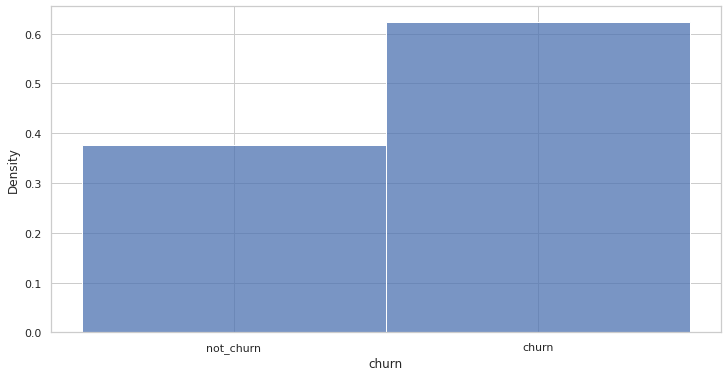

In [61]:
sns.histplot(churn, x='churn',stat="density")

##### 1. Проверим, влияет ли платформа на отток водителей

In [78]:
pd.crosstab(churn.churn, churn.phone)

phone,Android,iPhone
churn,,
churn,11872,19053
not_churn,3146,15525


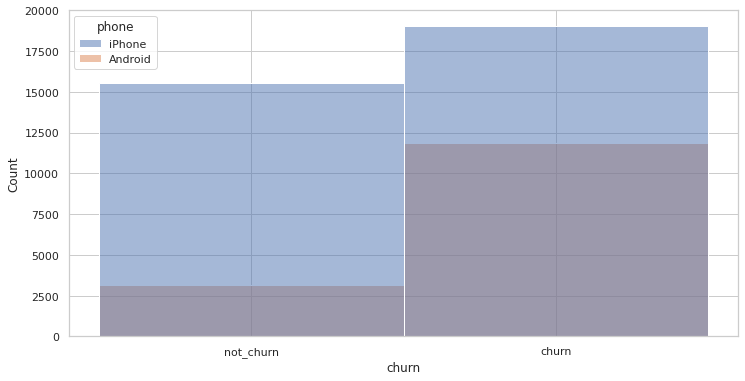

In [79]:
sns.histplot(churn[['churn', 'phone']].dropna(), x='churn', 
                   hue='phone')

##### Проверим гипотезу с помощью статистического теста

Так как есть две категориальные переменные, используем хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [104]:
stat, p1, dof, expected = chi2_contingency(pd.crosstab(churn.churn, churn.phone))

In [105]:
stat, p1

(2557.583739142147, 0.0)

*Интерпретируем результат*

In [110]:
prob = 0.95
alpha = 1.0 - prob
if p1 <= alpha:
    print('Отклоняем H0, есть различия в размерах оттока клиентов в зависимости от платформы телефона')
else:
    print('Не отклоняем H0, взаимосвязи между переменными нет')

Отклоняем H0, есть различия в размерах оттока клиентов в зависимости от платформы телефона


##### 2. Проверим, есть ли различия в размерах оттока клиентов в разных городах

In [89]:
pd.crosstab(churn.churn, churn.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12303,3767,15118
not_churn,4228,6363,8213


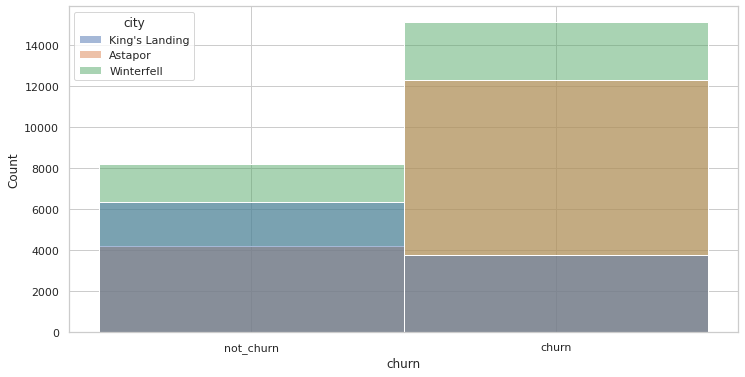

In [94]:
sns.histplot(churn[['churn', 'city']].dropna(), x='churn', 
                   hue='city')

##### Проверим гипотезу с помощью статистического теста

Так как есть две категориальные переменные, используем хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [107]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(churn.churn, churn.city))

In [108]:
stat, p

(3819.961524512801, 0.0)

In [111]:
prob = 0.95
alpha = 1.0 - prob
if p1 <= alpha:
    print('Отклоняем H0, есть различия в размерах оттока клиентов в разных городах')
else:
    print('Не отклоняем H0, взаимосвязи между переменными нет')

Отклоняем H0, есть различия в размерах оттока клиентов в разных городах


#####  3. Проверим, может ли отток быть связан с активностью в первые 30 дней после регистрации

In [127]:
df_churn = churn[churn.churn == 'churn'].trips_in_first_30_days
df_not_churn = churn[churn.churn == 'not_churn'].trips_in_first_30_days

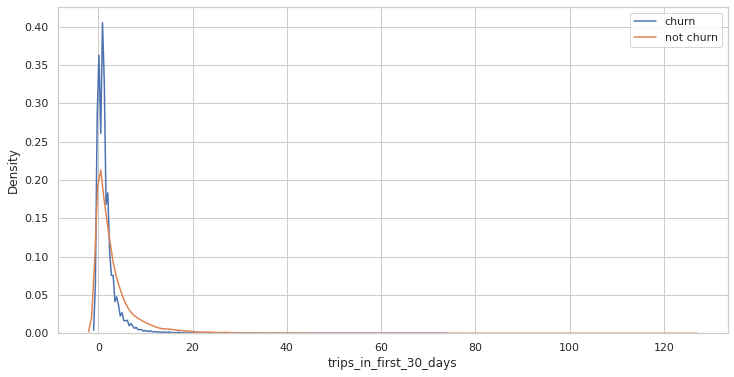

In [138]:
sns.kdeplot(df_churn, label='churn')
sns.kdeplot(df_not_churn, label='not churn')
plt.legend()

**Для проверки нормальности используем тест Шапиро-Уилка**
- $H_0$: распределение нормальное
- $H_1$: распределение не является нормальным

In [139]:
from scipy.stats import shapiro

In [144]:
pvalue_Sh = shapiro(churn.trips_in_first_30_days.sample(1000))[1]

In [148]:
if pvalue_Sh <= 0.05:
    print('Отклоняем H0, распределение не является нормальным')
else:
    print('Не отклоняем H0, распределение нормальное')

Отклоняем H0, распределение не является нормальным


Так как распределение переменной trips_in_first_30_days не является нормальным, для проверки гипотезы используем 
U-критерий Манна-Уитни

In [150]:
from scipy.stats import mannwhitneyu

In [155]:
stat, p = mannwhitneyu(df_churn, df_not_churn)
print('stat:',stat, 'pvalue:',p)

stat: 234710312.0 pvalue: 0.0


Результат оказался статистически значим. Значит, значимые различия есть, ушедшие пользователи были менее активны